<a href="https://colab.research.google.com/github/chanhyeong00/machine_learning_study/blob/main/pytorch-computer%20vision/%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EB%B6%84%EB%A5%98/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모델 구현

레즈넷은 한 개의 입력 줄기(input stem)와 내 게의 스테이지(stage)로 구성돼있다.

## 기본 블록

In [48]:
from torch import nn

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, inplanes, planes, stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(
        inplanes, planes,
        kernel_size=3, stride=stride, padding=1, bias=False
        # inplanes: 입력 특징맵의 차원수, planes: 출력 특징맵의 차원수
    )
    self.bn1 = nn.BatchNorm2d(planes)


    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(
        planes, planes,
        kernel_size=3, stride=1, padding=1, bias=False
    )
    self.bn2 = nn.BatchNorm2d(planes)


    self.shortcut = nn.Sequential() # 잔차 연결을 위한 빈 시퀀셜
    # 간격이 다르거나 입력값과 출력값의 차원이 동일하지 않은 경우
    if stride != 1 or inplanes != self.expansion*planes:
      # W_s 구현(즉, 차원을 맞춰줌)
      self.shortcut = nn.Sequential(
         # ** 차원 크기 맞춰주기 -> 잔차 연결로 output과 x를 더해야하기 떄문에 **
        nn.Conv2d(
          inplanes, self.expansion*planes,
          kernel_size=1, stride=stride, bias=False
        ),
        nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)
      out = self.conv2(out)
      out = self.bn2(out)
      out += self.shortcut(x) # ** 잔차연결(입력값을 출력값에 더한다) **
      out = self.relu(out)
      return out

**nn.ReLU(inplace=True)를 사용하면 입력 값 자체를 수정하여 출력 값으로 새로운 텐서를 생성하지 않고 직접 업데이트합니다. 이는 메모리를 절약하고 연산 속도를 향상시킬 수 있습니다.**

기본 블럭은 합성곱 계층이 64, 128, 256, 512차원(채널)로 구성된다.

VGG-16 에서는 최댓값 풀링을 통해 특징 맵의 크기를 감소시켰다면, 레즈넷에서는 간격을 활용해 특징 맵의 크기를 감소시킨다.



## 병목 블록


병목 블록은 앞서 구현한 기본 블록과 유사한 구조를 갖지만, **더 많은 합성곱 계층과 확장(expansion) 변수를 사용한다.**

병목블록에서 사용되는 확장값(expansion)은 병목 블록의 3번째 합성곱 계층에서 사용된다. 이 값은 출력 차원 수를 늘려 더 많은 특징을 학습하고 성능을 높이기 위해 사용된다.

In [50]:
from torch import nn

class BottleneckBlock(nn.Module):
  expansion = 4

  def __init__(self, inplanes, planes, stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(
        inplanes, planes,
        kernel_size=1, bias=False
    ) # 1x1 합성곱층
    self.bn1 = nn.BatchNorm2d(planes)

    self.conv2 = nn.Conv2d(
        planes, planes,
        kernel_size=3, stride=stride, padding=1, bias=False
    )
    self.bn2 = nn.BatchNorm2d(planes)

    self.conv3 = nn.Conv2d(
        planes, self.expansion*planes,
        kernel_size=1, bias=False
    ) # 1x1 합성곱층
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)
    self.relu = nn.ReLU(inplace=True)

    self.shortcut = nn.Sequential()
    if stride != 1 or inplanes != self.expansion*planes:
      self.shortcut = nn.Sequential(
         # ** 차원 크기 맞춰주기 -> 잔차 연결로 output과 x를 더해야하기 떄문에 **
        nn.Conv2d(
          inplanes, self.expansion*planes,
          kernel_size=1, stride=stride, bias=False
        ),
        nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)
      out = self.conv2(out)
      out = self.bn2(out)
      out = self.relu(out)
      out = self.conv3(out)
      out = self.bn3(out)
      out += self.shortcut(x) # ** 잔차연결(입력값을 출력값에 더한다) **
      out = self.relu(out)
      return out

일반적으로 깊은 레즈넷에서는 확장(expansion) 값을 4로 사용한다. 이 값으로 세 번쨰 합성곱 연산에서 출력 차원 수를 높여 모델의 복잡도와 매개변수의 수를 조절한다.

병목 블록은 합성곱 신경망의 구조와 확장을 제외한다면 기본 블록과 매우 유사한 코드로 반복된다.

## 레즈넷 모델

위의 코드들은 레즈넷에서 사용되는 기본 블록과 병목 블록이다.

이러한 블록이 여러번 반복해 하나의 스테이지를 구성한다. 그러므로 여러 블록을 묶는 스테이지 메서드를 구성해 레즈넷 모델을 구현한다.

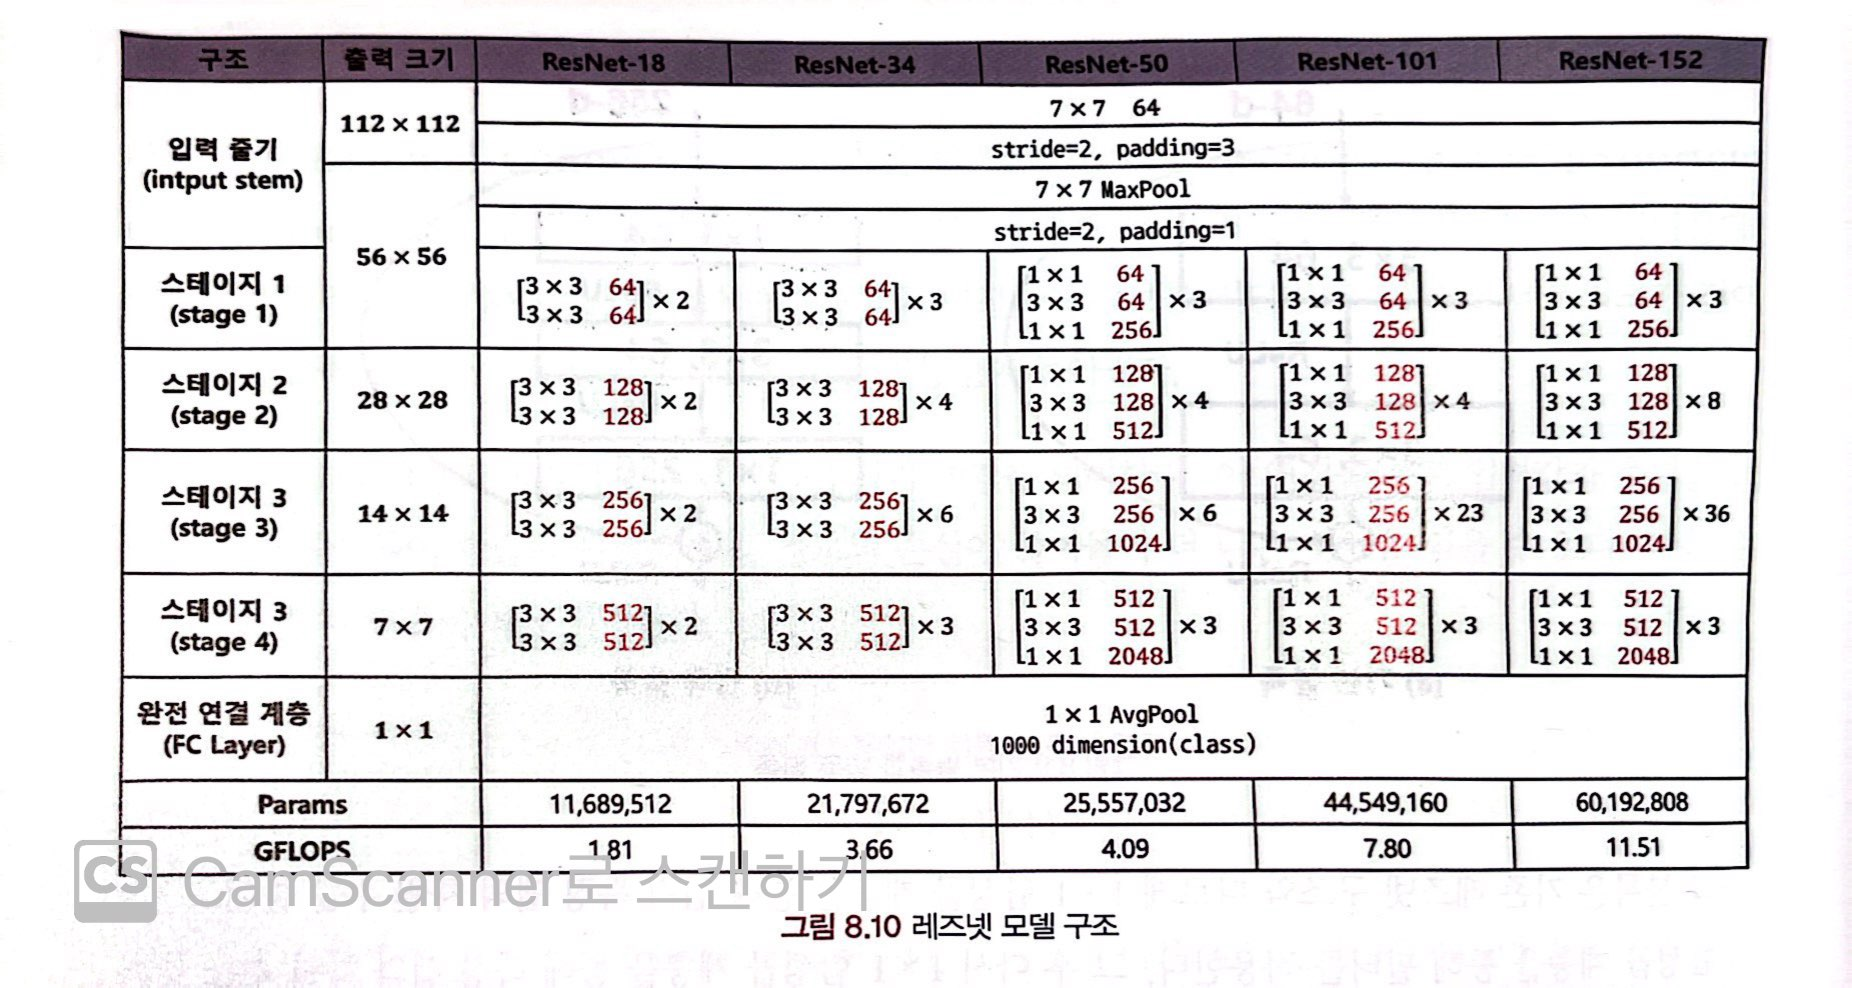

위의 구조처럼 stem과 stage를 구성한다.

입력 줄기의 합성곱 계층은 3채널 이미지를 전달받으므로 입력 데이터 차원의 크기는 3, 출력 데이터 차원의 크기는 64로 전달.

모든 라즈넷의 스테이지 시작점은 64, 128, 256, 512 차원으로 시작되며, 레즈넷 유형에 따라 반복되는 횟수가 다르다.

또한 두번쨰 스테이지부터는 합성곱 계층의 첫 간격을 2로 사용한다.

In [30]:
import torch


class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes=1000):
      super().__init__()

      self.inplanes = 64
      self.stem = nn.Sequential(
          nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
          nn.BatchNorm2d(self.inplanes),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )
      self.stage1 = self._make_layer(block, 64, layers[0], stride=1) # 첫 번째 스테이지 간격만 1
      self.stage2 = self._make_layer(block, 128, layers[1], stride=2)# 나머지 스테이지 2
      self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
      self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

      self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # 연산량 줄이기 위함?
      self.fc = nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
      layers = []
      layers.append(block(self.inplanes, planes, stride)) # 첫 번째 블록 간격 2
      # 블록 계층을 사용하는 스테이지는 입력 차원과 출력 차원을 다르게 전달하므로 inplanes 갱신
      self.inplanes = planes * block.expansion
      for _ in range(num_blocks - 1): # 나머지 블록들은 간격 1로
          layers.append(block(self.inplanes, planes, 1))

      return nn.Sequential(*layers)

  def forward(self, x):
      out = self.stem(x)
      out = self.stage1(out)
      out = self.stage2(out)
      out = self.stage3(out)
      out = self.stage4(out)
      out = self.avgpool(out)
      out = torch.flatten(out, 1)
      out = self.fc(out)
      return out

## 레즈넷 모델 비교

In [19]:
pip install torchinfo

In [49]:
from torchvision import models
from torchinfo import summary

# 레이어 개수에 따라 레즈넷 종류가 달라짐
resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 1000)
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 1000)
resnet50 = ResNet(BottleneckBlock, [3, 4, 6, 3], 1000)
resnet101 = ResNet(BottleneckBlock, [3, 4, 23, 3], 1000)
resnet152 = ResNet(BottleneckBlock, [3, 8, 36, 3], 1000)
torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

resnet34_info = summary(resnet34, (1, 3, 224, 224), verbose=0)
torch_model_info = summary(torch_model, (1, 3, 224, 224), verbose=0)
print(resnet34_info.total_params)
print(torch_model_info.total_params)


21797672
21797672


In [51]:
resnet50_info = summary(resnet50, (1, 3, 224, 224), verbose=0)
print(resnet50_info)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─BottleneckBlock: 2-5              [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│ 